# Reverse-Engineering Quantum Circuits

When studying the basics of quantum computing we start describing circuits with easy calculations on $2 \times 2$ or $4 \times 4$ matrices, but as soon as we explore the first algorithms we stumble upon oracles that seem to be too complex to be represented like that. But I like matrices: they are like functions that we can study regardless of the input. If we could describe any circuit as a simple combination of matrices, programming circuits would be similar to programming functions. There must be a way. Maybe I found one.

Let's start by importing the needed libraries and defining convenience functions to easily draw circuits and unitary matrices:

In [1]:
from qiskit import QuantumCircuit, execute, Aer
import math

def draw(circuit):
    return circuit.draw(output='mpl')

def unitary(circuit):
    unitary = execute(circuit, Aer.get_backend('unitary_simulator')).result().get_unitary()
    pretty_unitary = ''
    for row in range(len(unitary)):
        pretty_unitary += '|'
        for column in range(len(unitary[row])):
            value = unitary[row][column]
            if math.isclose(value.imag, 0, abs_tol=0.01):
                pretty_value = '{num.real:.0f}'.format(num=value)
            elif math.isclose(value.real, 0, abs_tol=0.01):
                pretty_value = '{num.imag:.0f}i'.format(num=value)
            else:
                pretty_value = '{num.real:.0f}+{num.imag:.0f}i'.format(num=value)
            
            pretty_unitary += pretty_value
            if column < len(unitary[row])-1:
                pretty_unitary += ' '
        pretty_unitary += '|\n'
    print(pretty_unitary)

Since we are going to deal with huge matrices, to make calculations simpler let's also define the following two "atomic" matrices:

$$
\bar{0} = |0\rangle\langle0| =
\begin{bmatrix}
1 & 0\\
0 & 0
\end{bmatrix}
\\[2em]
\bar{1} = |1\rangle\langle1| =
\begin{bmatrix}
0 & 0\\
0 & 1
\end{bmatrix}
$$

With these two atoms of computation we can define other matrices as a combination of them:

$$
I =
\begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}
=
\begin{bmatrix}
1 & 0\\
0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0\\
0 & 1
\end{bmatrix}
= \bar{0} + \bar{1}
\\[2em]
CX =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & \bar{1}\\
\bar{1} & \bar{0}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0\\
0 & \bar{0}
\end{bmatrix}
+
\begin{bmatrix}
0 & \bar{1}\\
\bar{1} & 0
\end{bmatrix}
= I \otimes \bar{0} + X \otimes \bar{1}
$$

Note how this last sum can be easily interpreted as: _"The second qubit remains the same if the first qubit is $|0\rangle$, but gets flipped if the first qubit is $|1\rangle$."_ That's exactly the description of a CNOT gate!

Now we are able to describe all gates as a combination of $2 \times 2$ matrices, which means we can:

1. Reverse-engineer huge unitary matrices by splitting them
2. Describe circuits by multiplying their single-qubit gates
3. "Forward-engineer" circuits by describing the result we expect from them!

## $CNOT_{01}$

We know how the CNOT gate works on a two-qubits circuit. We expect no surprises if we add a (completely useless) third qubit.

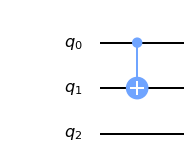

In [2]:
circuit = QuantumCircuit(3)
circuit.cx(0, 1)
draw(circuit)

The corresponding unitary matrix should be pretty straightforward, we just need to treat the missing gate in $q_2$ as an Identity matrix. Let's turn it into a combination of smaller matrices:

$$
I \otimes CX =
\begin{bmatrix}
CX & 0\\
0 & CX
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & \bar{1} & 0 & 0\\
\bar{1} & \bar{0} & 0 & 0\\
0 & 0 & \bar{0} & \bar{1}\\
0 & 0 & \bar{1} & \bar{0}
\end{bmatrix}\\
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & \bar{0}
\end{bmatrix}
+
\begin{bmatrix}
0 & \bar{1} & 0 & 0\\
\bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1}\\
0 & 0 & \bar{1} & 0
\end{bmatrix}\\
=
I \oplus I \oplus \bar{0} + I \oplus X \oplus \bar{1}
$$

Which we can interpret as: _"$q_1$ remains the same if $q_0$ is equal to $|0\rangle$, but gets flipped when it's $|1\rangle$; $q_2$ is irrelevant."_ This is exactly the same as describing a CNOT gate between $q_0$ and $q_1$, with an Identity matrix on $q_2$!

In [3]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 0 0 1 0 0 0 0|
|0 0 1 0 0 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 0 0 1 0 0 0|
|0 0 0 0 0 0 0 1|
|0 0 0 0 0 0 1 0|
|0 0 0 0 0 1 0 0|



## $\text{CNOT}_{12}$

Nothing much changes if the third qubit is instead positioned on top, to be the first one.

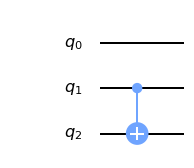

In [4]:
circuit = QuantumCircuit(3)
circuit.cx(1, 2)
draw(circuit)

Here we can also easily calculate the resulting unitary matrix and split it into a combination of smaller matrices, just like before:

$$
CX \otimes I =
\begin{bmatrix}
I & 0 & 0 & 0\\
0 & 0 & 0 & I\\
0 & 0 & I & 0\\
0 & I & 0 & 0
\end{bmatrix}\\
= \begin{bmatrix}
I & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & I & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 0 & 0 & I\\
0 & 0 & 0 & 0\\
0 & I & 0 & 0
\end{bmatrix}\\
= I \otimes \bar{0} \otimes I + X \otimes \bar{1} \otimes I
$$

The interpretation is pretty similar to the previous, only the order changes: _"$q_2$ remains the same if $q_1$ is equal to $|0\rangle$, but gets flipped if $q_1$ is $|1\rangle$; $q_0$ is irrelevant."_

In [5]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 0 0 0 0 1 0|
|0 0 0 0 0 0 0 1|
|0 0 0 0 1 0 0 0|
|0 0 0 0 0 1 0 0|
|0 0 1 0 0 0 0 0|
|0 0 0 1 0 0 0 0|



## $\text{CNOT}_{02}$

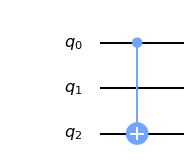

In [6]:
circuit = QuantumCircuit(3)
circuit.cx(0, 2)
draw(circuit)

Here it gets trickier, because the $I$ is between the control and the target of the CNOT. I have no idea how to build this matrix, so I'll leave this calculation to Qiskit:

In [7]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 0 0 0 0 1 0 0|
|0 0 1 0 0 0 0 0|
|0 0 0 0 0 0 0 1|
|0 0 0 0 1 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 0 0 0 0 1 0|
|0 0 0 1 0 0 0 0|



We can see this matrix as:

$$
\begin{bmatrix}
\bar{0} & 0 & \bar{1} & 0\\
0 & \bar{0} & 0 & \bar{1}\\
\bar{1} & 0 & \bar{0} & 0\\
0 & \bar{1} & 0 & \bar{0}
\end{bmatrix}\\
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & \bar{0}
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & \bar{1} & 0\\
0 & 0 & 0 & \bar{1}\\
\bar{1} & 0 & 0 & 0\\
0 & \bar{1} & 0 & 0
\end{bmatrix}\\
=
I \otimes I \otimes \bar{0} + X \otimes I \otimes \bar{1}
$$

Which could be interpreted as: _"$q_2$ remains the same if $q_0$ is equal to $|0\rangle$, but gets flipped when $q_0$ is $|1\rangle$; $q_1$ is irrelevant."_ This is exactly like the previous two gates, but again in a different order!

Now that we know how to reverse-engineer a unitary matrix into a circuit, is it also possible to do the opposite, by describing the circuit as its constituent gates, or even intuitively "forward-engineer" a circuit into a matrix? Let's try it out with the oracles described in real case scenarios.

## Quantum Teleportation: $\text{CNOT}_{12} \cdot \text{CNOT}_{01}$

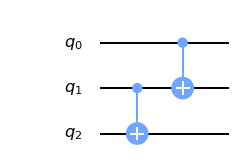

In [8]:
circuit = QuantumCircuit(3)
circuit.cx(1, 2)
circuit.cx(0, 1)
draw(circuit)

Let's describe this circuit gate by gate:

$$
(I \otimes I \otimes \bar{0} + I \otimes X \otimes \bar{1}) \cdot (I \otimes \bar{0} \otimes I + X \otimes \bar{1} \otimes I)
$$

Once we perform the multiplication we get this result:

$$
= I \otimes \bar{0} \otimes \bar{0} + X \otimes \bar{1} \otimes \bar{0} + I \otimes X \cdot \bar{0} \otimes \bar{1} + X \otimes X \cdot \bar{1} \otimes \bar{1}
$$

An interpretation could be: _"if $q_0$ is $|0\rangle$ then $q_2$ depends solely on $q_1$; if $q_0$ is $|1\rangle$ then $q_1$ will flip and $q_2$ will follow depending on the value of $q_1$."_

Note that adding Hadamard gates doens't add much to the result:

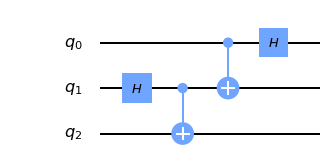

In [15]:
circuit = QuantumCircuit(3)
circuit.h(1)
circuit.cx(1, 2)
circuit.cx(0, 1)
circuit.h(0)
draw(circuit)

$$
(I \otimes I \otimes H) \cdot\\
(I \otimes I \otimes \bar{0} + I \otimes X \otimes \bar{1}) \cdot (I \otimes \bar{0} \otimes I + X \otimes \bar{1} \otimes I) \cdot\\
(I \otimes H \otimes I)
$$

$$
= I \otimes \bar{0} \cdot H \otimes H \cdot \bar{0} + X \otimes \bar{1} \cdot H \otimes H \cdot \bar{0} + I \otimes X \cdot \bar{0} \cdot H \otimes H \cdot \bar{1} + X \otimes X \cdot \bar{1} \cdot H \otimes H \cdot \bar{1}
$$

## Deutsch-Josza: $\text{CNOT}_{02} \cdot \text{CNOT}_{12}$

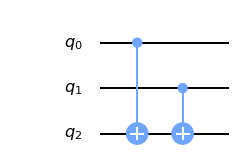

In [9]:
circuit = QuantumCircuit(3)
circuit.cx(0, 2)
circuit.cx(1, 2)
draw(circuit)

What does this circuit mean? How does it work? Let's reverse-engineer it by having a look at the computed unitary matrix:

In [10]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 0 0 0 0 1 0 0|
|0 0 0 0 0 0 1 0|
|0 0 0 1 0 0 0 0|
|0 0 0 0 1 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 1 0 0 0 0 0|
|0 0 0 0 0 0 0 1|



The matrix looks like the following:

$$
\begin{bmatrix}
\bar{0} & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & \bar{0}\\
\bar{1} & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & \bar{1}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0}\\
0 & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & 0\\
\bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1}
\end{bmatrix}\\
= CX \otimes \bar{0} + X \otimes I \otimes I \cdot CX \otimes \bar{1}
$$

Let's go a little further by expanding the CNOT gates:

$$
= (I \otimes \bar{0} \otimes \bar{0} + X \otimes \bar{1} \otimes \bar{0}) + (X \otimes I \otimes I) \cdot (I \otimes \bar{0} \otimes \bar{1} + X \otimes \bar{1} \otimes \bar{1})
$$

And now, applying the product:

$$
= I \otimes \bar{0} \otimes \bar{0} + X \otimes \bar{1} \otimes \bar{0} + X \otimes \bar{0} \otimes \bar{1} + I \otimes \bar{1} \otimes \bar{1}
$$

Which could be interpreted as: _"$q_2$ is flipped if only one of the other two is equal to $|1\rangle$. In any other case it stays the same."_ It looks like a XOR which keeps the inputs in $q_0$ and $q_1$ and holds the output in $q_2$. Now it makes sense!

Note that the result we found suggests to split the matrix in the following way, which is equivalent:

$$
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0}\\
0 & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & \bar{1} & 0\\
0 & 0 & 0 & 0\\
\bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & \bar{1} & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & \bar{0}\\
\bar{1} & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & \bar{1}
\end{bmatrix}
$$

We could also describe the circuit as the sequence of its gates:

$$
(I \otimes \bar{0} \otimes I + X \otimes \bar{1} \otimes I) \cdot (I \otimes I \otimes \bar{0} + X \otimes I \otimes \bar{1})
$$

Now performing the multiplication:

$$
= I \otimes \bar{0} \otimes \bar{0} + X \otimes \bar{0} \otimes \bar{1} + X \otimes \bar{1} \otimes \bar{0} + I \otimes \bar{1} \otimes \bar{1}
$$

Which is exactly the result we got with reverse-engineering.

## Simon's Oracle: $CNOT_{02} \cdot CNOT_{03} \cdot CNOT_{12} \cdot CNOT_{13}$

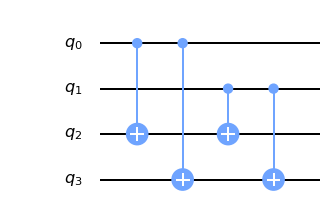

In [16]:
circuit = QuantumCircuit(4)
circuit.cx(0, 2)
circuit.cx(0, 3)
circuit.cx(1, 2)
circuit.cx(1, 3)
draw(circuit)

Let's try another "forward-engineer". The circuit could be descibed as:

1. _"$q_2$ is flipped if $q_0$ or $q_1$ is $|1\rangle$"_
2. _"$q_3$ is flipped if $q_0$ or $q_1$ is $|1\rangle$"_
3. _"Any other case doesn't change the state of "$q_2$ or "$q_3$"_

Now, in maths:

$$
\text{1. } (I \otimes X \otimes \bar{0} \otimes \bar{1}) + (I \otimes X \otimes \bar{1} \otimes \bar{0})\\
\text{2. } (X \otimes I \otimes \bar{0} \otimes \bar{1}) + (X \otimes I \otimes \bar{1} \otimes \bar{0})\\
\text{3. } (I \otimes I \otimes \bar{0} \otimes \bar{0}) + (I \otimes I \otimes \bar{1} \otimes \bar{1})
$$

We can simplify even further by combining 1. and 2. together, since both target qubits are flipped at the same time:

$$
\text{1+2. } (X \otimes X \otimes \bar{0} \otimes \bar{1}) + (X \otimes X \otimes \bar{1} \otimes \bar{0})\\
\text{3. } (I \otimes I \otimes \bar{0} \otimes \bar{0}) + (I \otimes I \otimes \bar{1} \otimes \bar{1})
$$

If the description is correct, the resulting matrix should be:

$$
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & \bar{1} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \bar{0}\\
0 & 0 & 0 & 0 & \bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{1} & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0} & 0 & 0 & 0 & 0\\
\bar{1} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
\bar{0} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & \bar{1} & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \bar{0} & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1} & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & \bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \bar{1} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \bar{1}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0 & 0 & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & 0 & 0 & 0 & 0 & \bar{0}\\
0 & 0 & \bar{0} & 0 & \bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1} & 0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{1} & 0 & \bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0} & 0 & \bar{1} & 0 & 0\\
\bar{1} & 0 & 0 & 0 & 0 & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & 0 & 0 & 0 & 0 & \bar{1}
\end{bmatrix}
$$

Will it work?

In [12]:
unitary(circuit)

|1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0|
|0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0|
|0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0|
|0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0|
|0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1|



It does! Now we are able to easily build and understand circuits, using just our common sense!

In [13]:
# IceOnFire